## Description

Dataset ini adalah data tahun 2020 yang berisi tentang pasein <i>Cardiovascular Diseases (CVDs)</i>, dengan 12 Fitur yang dapat digunakan untuk memprediksi kematian akibat gagal jantung.

### Objective

Melakukan prediksi terhadap pasien, apakah akan menderita penyakit CVDs atau tidak.

### Note

Menggunakan beberapa machine learning untuk dijadikan bahan pertimbangan, diantaranya :
1. Decision Tree
2. Gradient Boost

untuk detail mengenai dataset, dapat di baca pada link berikut:

https://www.kaggle.com/andrewmvd/heart-failure-clinical-data/discussion/193109

# 1. Import Library

In [31]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp


from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from feature_engine.outliers import Winsorizer


In [32]:
# common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV


# preprocessing data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from feature_engine.outliers import Winsorizer, OutlierTrimmer


# model machine learning
from sklearn.ensemble import RandomForestClassifier     # Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boost


# evalutation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# ignore warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 2. Load Data

In [88]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df = data.copy()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [90]:
df[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']] = df[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']].astype(object)
df['age'] = df['age'].astype(int)

# 3. Exploratory Data Analysis

### Jumlah kematian karena penyakit

In [91]:
anaemia = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 1) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 0)]
diabetes = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 0) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 0)]
hbp = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 0) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 1)]

anaemia_and_diabetes = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 1) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 0)]
anaemia_and_hbp = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 1) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 1)]
diabetes_and_hbp = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 0) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 1)]

death_with_diseases = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 1) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 1)]
death_with_no_diseases = df[(df['DEATH_EVENT'] == 1) & (df['anaemia'] == 0) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 0)]

In [92]:
penyakit = ['anaemia', 'diabetes', 'tekanan darah tinggi', 'anaemia dan diabetes', 'anaemia dan tekanan darah tinggi', 'diabetes dan tekanan darah tinggi', 'komplikasi 3 penyakit', 'tanpa penyakit']

fig = go.Figure()
fig.add_trace(go.Bar(
    x= penyakit,
    y=[anaemia.shape[0], diabetes.shape[0], hbp.shape[0], anaemia_and_diabetes.shape[0], anaemia_and_hbp.shape[0], diabetes_and_hbp.shape[0], death_with_diseases.shape[0], death_with_no_diseases.shape[0]]
))

fig.update_layout(barmode='group', title='penyakit vs meninggal')
fig.show()

`dari 96 orang yang meninggal, beberapa diantaranya menginggal karena mengidap penyakit, diantaranya:`

`- 15 orang yang hanya mengidap penyakit anaemia`

`- 11 orang yang hanya mengidap penyakit diabetes`

`- 9 orang yang hanya mengidap penyakit tekanan darah tinggi`

`- 12 orang yang hanya mengidap penyakit anaemia dan diabetes`

`- 13 orang yang hanya mengidap penyakit anaemia dan tekanan darah tinggi`

`- 11 orang yang hanya mengidap penyakit diabetes dan tekanan darah tinggi`

`- 6 orang yang hanya mengidap penyakit ketiga penyakit tersebut`

`- 19 orang yang tidak mengidap penyakit apapun`

In [93]:
anaemia_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 1) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 0)]
diabetes_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 0) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 0)]
hbp_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 0) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 1)]

anaemia_and_diabetes_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 1) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 0)]
anaemia_and_hbp_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 1) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 1)]
diabetes_and_hbp_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 0) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 1)]

death_with_diseases_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 1) & (df['diabetes'] == 1) & (df['high_blood_pressure'] == 1)]
death_with_no_diseases_nd = df[(df['DEATH_EVENT'] == 0) & (df['anaemia'] == 0) & (df['diabetes'] == 0) & (df['high_blood_pressure'] == 0)]

### Jumlah orang yang masih hidup tapi terkena penyakit

In [94]:
penyakit = ['anaemia', 'diabetes', 'tekanan darah tinggi', 'anaemia dan diabetes', 'anaemia dan tekanan darah tinggi', 'diabetes dan tekanan darah tinggi', 'komplikasi 3 penyakit', 'tanpa penyakit']

fig = go.Figure()
fig.add_trace(go.Bar(
    x= penyakit,
    y=[anaemia_nd.shape[0], diabetes_nd.shape[0], hbp_nd.shape[0], anaemia_and_diabetes_nd.shape[0], anaemia_and_hbp_nd.shape[0], diabetes_and_hbp_nd.shape[0], death_with_diseases_nd.shape[0], death_with_no_diseases_nd.shape[0]]
))

fig.update_layout(barmode='group', title='penyakit vs hidup')
fig.show()

`selain itu dari 203 orang yang masih hidup juga mengidap penyakit, diantaranya:`

`- 30 orang yang hanya mengidap penyakit anaemia`

`- 35 orang yang hanya mengidap penyakit diabetes`

`- 22 orang yang hanya mengidap penyakit tekanan darah tinggi`

`- 24 orang yang hanya mengidap penyakit anaemia dan diabetes`

`- 18 orang yang hanya mengidap penyakit anaemia dan tekanan darah tinggi`

`- 15 orang yang hanya mengidap penyakit diabetes dan tekanan darah tinggi`

`- 11 orang yang hanya mengidap penyakit ketiga penyakit tersebut`

`- 48 orang yang tidak mengidap penyakit apapun`

### Jumlah kematian berdasarkan jenis kelamin

In [95]:
fig = px.histogram(df, x= 'sex', color='DEATH_EVENT', title= 'Death Event vs Sex')
fig.show()

`terlihat laki laki lebih banyak yang meninggal dibanding perempuan, dengan jumlah laki-laki sebanyak 62 orang dan perempuan sebanyak 34 orang`

### Jumlah kematian karena merokok

In [96]:
fig = px.histogram(df, x='smoking', color= 'DEATH_EVENT', title= 'Death Event vs Smoking')
fig.show()

`terlihat bahwa lebih banyak orang yang meniggal karena tidak merokok dibanding dengan yang merokok, jumlah orang yang meninggal karena merokok adalah 30 orang sedangkan yang tidak merokok ada 66 orang`

### Jumlah kematian berdasarkan umur

In [97]:
fig = px.histogram(df, x= 'age', color='DEATH_EVENT', title= 'Death Event vs Age')
fig.show()

`jika dilihat berdasarkan umur, rentang umur 60-64 tahun adalah umur yang paling banyak menginggal karena gagal jantung dengan jumlah 15 orang, untuk lebih rincinya dapat dilihat sebagai berikut:`

`- umur 40-64 tahun : 1`

`- umur 45-49 tahun : 10`

`- umur 50-54 tahun : 11`

`- umur 55-59 tahun : 9`

`- umur 60-64 tahun : 15`

`- umur 65-69 tahun : 12`

`- umur 70-74 tahun : 13`

`- umur 75-79 tahun : 7`

`- umur 80-84 tahun : 8`

`- umur 85-89 tahun : 5`

`- umur 90-94 tahun : 3`

`- umur 95-99 tahun : 2`

### Jumlah kematian dan jumlah kadar natrium dalam darah

In [98]:
fig = px.histogram(df, x = 'serum_sodium', color ='DEATH_EVENT' ,title= 'Death Event vs Serum Sodium')
fig.show()

`pada kondisi normal, kadar natrium dalam darah adalah 135 - 145 mEq/L.`

`sedangkan rata - rata orang yang meniggal memiliki jumlah kadar natrium yang normal di dalam darahnya. namun jumlah kematian tertinggi dengan jumlah 17 orang memiliki kadar natrium kurang dari 145 mEq/L yaitu 134 mEq/L`

`sumber : `https://www.alodokter.com/hiponatremia

### Jumlah kematian dan kadar kreatinin dalam darah

In [99]:
death = df[df['DEATH_EVENT'] == 1]

In [100]:
fig = px.histogram(death, x = 'serum_creatinine', color= 'sex',  title= 'Death Event vs Serum Creatinine')
fig.show()

`pada kondisi normal, kadar kreatin dalam darah adalah 0.6 - 1.2 mg/dL untuk pria dewasa dan 0.5 - 1.1 mg/dL untuk wanita dewasa.`

`sedangkan rata - rata orang yang meniggal memiliki jumlah kadar kreatin yang normal di dalam darahnya dan juga jumlah kematian tertinggi dengan jumlah sekitar 28 untuk pria dan 14 orang untuk wanita memiliki kadar kreatin yang normal`

`sumber : `https://hellosehat.com/urologi/pemeriksaan-kreatinin/

In [101]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [102]:
fig = px.histogram(death, x = 'creatinine_phosphokinase', color = 'sex', nbins=500, title= 'Death Event vs Creatinine Phosphokinase (CPK)')
fig.show()

`pada kondisi normal, kadar Kreatin fosfokinase (CKP) dalam darah adalah 39 - 308 U/L untuk pria dewasa dan 26 - 198 U/L untuk wanita dewasa.`

`rata - rata orang yang meniggal memiliki jumlah kadar Kreatin fosfokinase (CKP) yang tidak normal di dalam darahnya serta  jumlah kematian tertinggi untuk kasus pria adalah 13 dengan kadar Kreatin fosfokinase (CKP) sekitar 580 - 599 U/L dan jumlah kasus wanita tertinggi adalah 5 untuk kadar Kreatin fosfokinase (CKP) sekitar 580 - 599 U/L dan 5 kasus untuk kadar Kreatin fosfokinase (CKP) sekitar 120 - 139 U/L`

`sumber : `https://www.sehatq.com/tindakan-medis/tes-kreatin-fosfokinase-cpk

In [103]:
fig = px.histogram(death, x = 'platelets', title= 'Death Event vs Platelets')
fig.show()

`pada kondisi normal, jumlah trombosit dalam darah adalah 150.000 - 400.000 trombosit per mikroliter.`

`rata - rata orang yang meniggal memiliki jumlah trombosit yang normal di dalam darahnya. namun jumlah kematian tertinggi dengan jumlah 24 orang memiliki jumlah tombosit sekitar 250.000 - 299.000 trombosit per mikroliter dalam darahnya`

`sumber : `https://www.alodokter.com/ini-pentingnya-jumlah-trombosit-normal-dalam-darah-anda#:~:text=Trombosit%20(platelet)%20dikenal%20juga%20dengan,oleh%20gangguan%20pada%20penggumpalan%20darah.



### Distribution Data

In [104]:
fig = make_subplots(rows=3, cols=3, subplot_titles = ('age', 'ejection fraction', "platelets", 'serum sodium', 'serum creatinine', 'creatinine phosphokinase', 'time'))

umur = go.Histogram(x = df['age'])
ejection = go.Histogram(x = df['ejection_fraction'])
trombosit = go.Histogram(x = df['platelets'])
sodium = go.Histogram(x = df['serum_sodium'])
kreatin = go.Histogram(x = df['serum_creatinine'])
cpk = go.Histogram(x = df['creatinine_phosphokinase'])
time = go.Histogram(x = df['time'])

fig.append_trace(umur, 1, 1)
fig.append_trace(ejection, 1, 2)
fig.append_trace(trombosit, 1, 3)
fig.append_trace(sodium, 2, 1)
fig.append_trace(kreatin, 2, 2)
fig.append_trace(cpk, 2, 3)
fig.append_trace(time, 3, 1)

fig.update_layout(showlegend=False, title_text="Data Distribution by Death")
fig.show()


`terlihat bahwa fitur age, ejection fraction, platelets, serum sodium, dan time memiliki distribusi data normal, sedangkan serum creatinine dan creatinine phosphokinase memiliki distribusi skewness`

## 4. Preprocessor

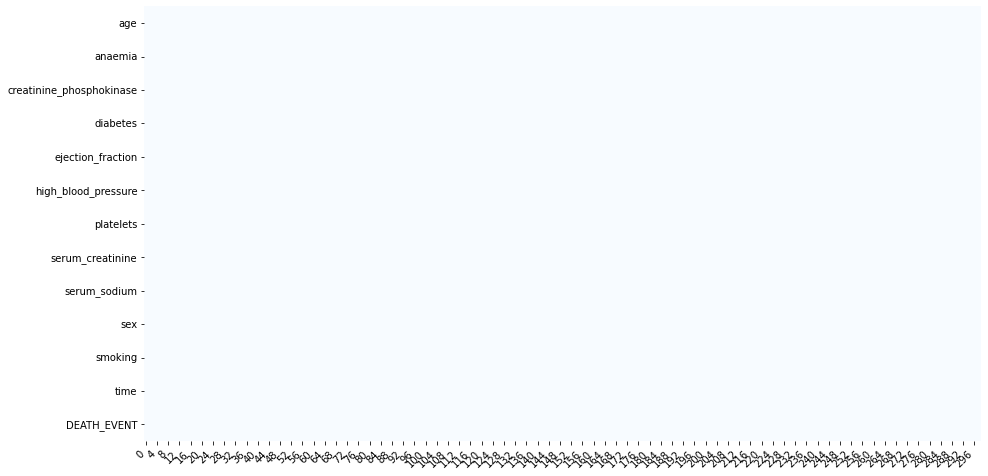

In [106]:
plot_missing_value(df)

`terlihat bahwa tidak ada missing value pada dataset`

In [107]:
df.shape

(299, 13)

In [108]:
X = df.drop(columns="DEATH_EVENT")
y = df["DEATH_EVENT"]
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239, 12), (60, 12), (239,), (60,))

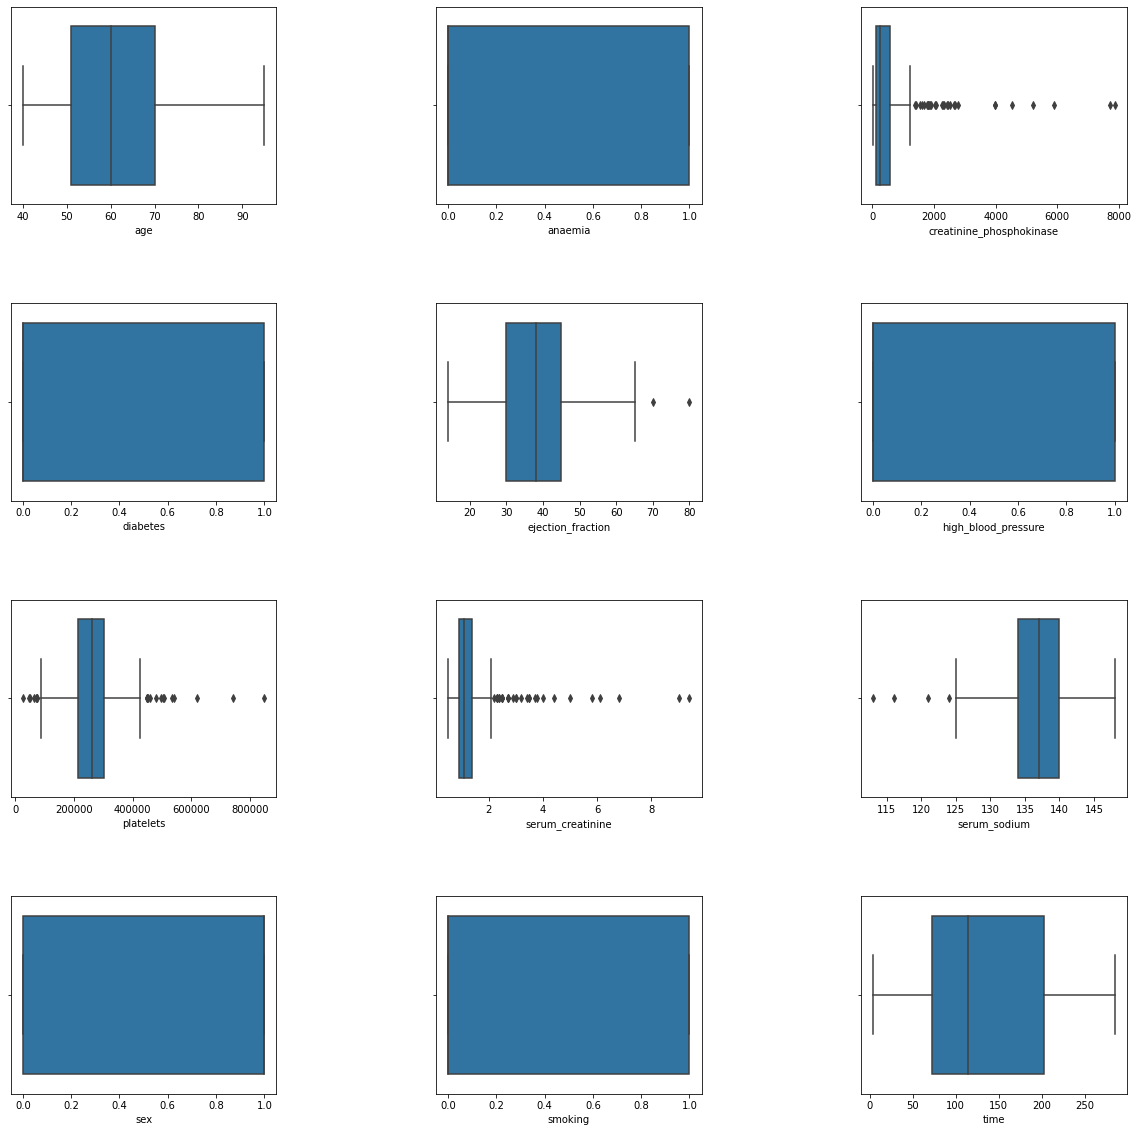

In [109]:
fig = plt.figure()
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace=0.5, wspace=0.6)

jum = 1
for i in range(len(X_train.columns)):
    ax = fig.add_subplot(4, 3, jum)
    sns.boxplot(x= X_train.columns[i], data=df)
    # plt.title(X_train[numerik].columns[i])
    jum+= 1

In [111]:
windsoriser_gaussian = Winsorizer(capping_method='gaussian', 
                          tail='both', 
                          fold=1.5,
                          variables=['platelets'])

windsoriser_skewness = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['creatinine_phosphokinase', 'serum_creatinine', 'serum_sodium'])

In [122]:
preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling='minmax', transform='box-cox'), ["serum_sodium", 'serum_creatinine', 'creatinine_phosphokinase', 'time']),
    ('numeric2', num_pipe(scaling='standard', transform= 'yeo-johnson'), ["age", 'ejection_fraction', 'platelets']),
    ('categoric1', cat_pipe(encoder='ordinal'), ["anaemia", 'diabetes', 'high_blood_pressure', 'sex', 'smoking'])   
])

In [124]:
pipeline_rf = Pipeline([
    ('outlier_1', windsoriser_gaussian),
    ('outlier_2', windsoriser_skewness),
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [125]:
model = GridSearchCV(pipeline_rf, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 200}
0.9205020920502092 0.8452004219409283 0.8166666666666667


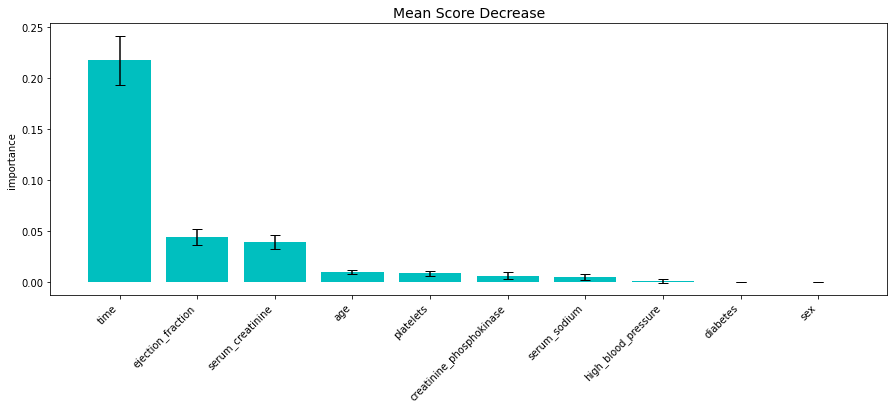

In [120]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

## Phase 2 : Feature Importance

In [126]:
windsoriser_gaussian = Winsorizer(capping_method='gaussian', 
                          tail='both', 
                          fold=1.5,
                          variables=['platelets'])

windsoriser_skewness = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['creatinine_phosphokinase', 'serum_creatinine', 'serum_sodium'])

preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling='minmax'), ["serum_sodium", 'serum_creatinine', 'creatinine_phosphokinase', 'time']),
    ('numeric2', num_pipe(scaling='standard'), ["age", 'ejection_fraction', 'platelets']),
    ('categoric1', cat_pipe(encoder='ordinal'), ['high_blood_pressure'])
])

pipeline_rf = Pipeline([
    ('outlier_1', windsoriser_gaussian),
    ('outlier_2', windsoriser_skewness),
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [127]:
model = GridSearchCV(pipeline_rf, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.8536392405063292 0.8166666666666667


## Phase 3 : Try Polynomial after feature selection

In [129]:
windsoriser_gaussian = Winsorizer(capping_method='gaussian', 
                          tail='both', 
                          fold=1.5,
                          variables=['platelets'])

windsoriser_skewness = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['creatinine_phosphokinase', 'serum_creatinine', 'serum_sodium'])

preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling='minmax', poly = 2), ["serum_sodium", 'serum_creatinine', 'creatinine_phosphokinase', 'time']),
    ('numeric2', num_pipe(scaling='standard', poly = 2), ["age", 'ejection_fraction', 'platelets']),
    ('categoric1', cat_pipe(encoder='ordinal'), ['high_blood_pressure'])
])

pipeline_rf = Pipeline([
    ('outlier_1', windsoriser_gaussian),
    ('outlier_2', windsoriser_skewness),
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [130]:

model = GridSearchCV(pipeline_rf, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 150}
0.8786610878661087 0.8453059071729957 0.85


## Phase 4: Randomized Search CV

In [145]:
windsoriser_gaussian = Winsorizer(capping_method='gaussian', 
                          tail='both', 
                          fold=1.5,
                          variables=['platelets'])

windsoriser_skewness = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['creatinine_phosphokinase', 'serum_creatinine', 'serum_sodium'])

preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling='minmax', poly = 4), ["serum_sodium", 'serum_creatinine', 'creatinine_phosphokinase', 'time']),
    ('numeric2', num_pipe(scaling='standard', poly = 4), ["age", 'ejection_fraction', 'platelets']),
    ('categoric1', cat_pipe(encoder='ordinal'), ['high_blood_pressure'])
])

pipeline_rf = Pipeline([
    ('outlier_1', windsoriser_gaussian),
    ('outlier_2', windsoriser_skewness),
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline_rf, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 70, 'algo__max_features': 0.12828626711806085, 'algo__min_samples_leaf': 7, 'algo__n_estimators': 151}
0.899581589958159 0.8578059071729958 0.8333333333333334
